# **AN2DL Challenge 2 - Image Classification**


In [1]:
# Enviroment
isColab = False
isKaggle = False
isWsl = True

# Set seed for reproducibility
SEED = 42

## **Loading Enviroment**


In [2]:
import os

# Directory di default
current_dir = os.getcwd()   

if isColab:
    from google.colab import drive
    
    drive.mount("/gdrive")
    current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/[2025-2026]\\ AN2DL/AN2DL-challenge-2"
    print("In esecuzione su Colab. Google Drive montato.")
    %cd $current_dir
elif isKaggle:
    kaggle_work_dir = "/kaggle/working/AN2DL-challenge-2"
    os.makedirs(kaggle_work_dir, exist_ok=True)
    current_dir = kaggle_work_dir
    print("In esecuzione su Kaggle. Directory di lavoro impostata.")
    os.chdir(current_dir)
elif isWsl:
    local_pref = r"/mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Esecuzione su WSL. Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)
else:
    print("Esecuzione locale. Salto mount Google Drive.")
    local_pref = r"G:\Il mio Drive\Colab Notebooks\[2025-2026] AN2DL\AN2DL-challenge-2"
    current_dir = local_pref if os.path.isdir(local_pref) else os.getcwd()
    print(f"Directory corrente impostata a: {current_dir}")
    os.chdir(current_dir)

print(f"Changed directory to: {current_dir}")

Esecuzione su WSL. Directory corrente impostata a: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2
Changed directory to: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2


## **Import Libraries**


In [3]:
# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
%pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
if isColab or isKaggle:
    !pkill -f tensorboard
    !mkdir -p models
    print("Killed existing TensorBoard instances and created models directory.")
else:
    os.makedirs("../models", exist_ok=True)
    
%load_ext tensorboard


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
PyTorch version: 2.9.1+cu128
Device: cpu
Note: you may need to restart the kernel to use updated packages.
PyTorch version: 2.9.1+cu128
Device: cpu


## **Dataset Downloading**


In [4]:
dataset_dir = os.path.join(current_dir, "dataset")

if isColab:
    # Clean up path for Python usage (remove shell escapes)
    clean_current_dir = current_dir.replace('\\ ', ' ')
    drive_dataset_dir = os.path.join(clean_current_dir, "dataset")
    local_dataset_dir = "/content/dataset"
    
    if not os.path.exists(local_dataset_dir):
        print(f"Copying dataset from {drive_dataset_dir} to {local_dataset_dir}...")
        try:
            shutil.copytree(drive_dataset_dir, local_dataset_dir)
            print("Copy complete.")
        except Exception as e:
            print(f"Error copying dataset: {e}")
            print("Falling back to Drive dataset (slow).")
            # If copy fails, we stick to the original dataset_dir (which might need cleaning too if it was used directly)
            dataset_dir = drive_dataset_dir
    else:
        print("Dataset already copied to local runtime.")
    
    # If copy succeeded (or already existed), use local path
    if os.path.exists(local_dataset_dir):
        dataset_dir = local_dataset_dir

elif isKaggle:
    # Nothing to do, dataset is already available in Kaggle environment
    print("Running on Kaggle. Dataset is assumed to be already available.")
    print(f"Dataset directory: {dataset_dir}")
else:
    # Check if dataset is already downloaded
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir, exist_ok=True)
        
    if not os.listdir(dataset_dir):
        print("Downloading dataset from Kaggle in local environment...")
        os.chdir(dataset_dir)
        !kaggle competitions download -c an2dl2526c2
        zip_file = "an2dl2526c2.zip"
        shutil.unpack_archive(zip_file, extract_dir=".")
        os.remove(zip_file)
        os.chdir(current_dir)
    else:
        print("Dataset already present in local environment. Skipping download.")

# Define absolute paths
train_set_dir = os.path.join(dataset_dir, "train_data")
test_set_dir = os.path.join(dataset_dir, "test_data")
label_file = os.path.join(dataset_dir, "train_labels.csv")
        
print(f"Dataset directory: {dataset_dir}")
print(f"Train set directory: {train_set_dir}")
print(f"Test set directory: {test_set_dir}")
print(f"Label file: {label_file}")

Dataset already present in local environment. Skipping download.
Dataset directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset
Train set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_data
Test set directory: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/test_data
Label file: /mnt/g/Il mio Drive/Colab Notebooks/[2025-2026] AN2DL/AN2DL-challenge-2/dataset/train_labels.csv


## ⏳ **Data Loading**


In [5]:
# Loader parameters
APPLY_MASK = False
BATCH_SIZE = 32
LOADER_SHUFFLE = False

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

LABEL_MAP = {"Luminal A": 0, "Luminal B": 1, "HER2(+)": 2, "Triple negative": 3}
IMG_RESIZE = (128, 128)
input_shape = (3, *IMG_RESIZE)
num_classes = len(LABEL_MAP)

TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2
TRAIN_SET_SIZE = 1.0 - TEST_SET_SIZE - VAL_SET_SIZE

In [6]:
train_augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ]
)

# No augmentation for validation/test
transform = transforms.Compose(
    [
        transforms.Resize(IMG_RESIZE, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

### **Definitions**


In [7]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import numpy as np


class IronGutsDataset(Dataset):
    """
    Custom Dataset for the Iron-Guts (Breast Cancer) competition.

    Features:
    1. Lazy Loading: Reads images from disk on-the-fly to save RAM.
    2. Integrity Checks: Ensures every image has a corresponding mask.
    3. Mask Gating: Uses the binary mask to suppress background noise (setting it to pure black).
    """

    def __init__(
        self,
        root_dir,
        data,
        transform=None,
        augmentation=None,
        target_transform=None,
        apply_mask=False,
    ):
        """
        Args:
            root_dir (str): Directory with all images and masks.
            data (str or pd.DataFrame): Path to the CSV file with annotations or the DataFrame itself.
            transform (callable, optional): Transform to be applied on the image (e.g., Resize, ToTensor).
            augmentation (callable, optional): Augmentation transforms to be applied on the image.
            target_transform (callable, optional): Transform to be applied on the label.
            apply_mask (bool, optional): Whether to apply mask gating. Default: True.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation
        self.target_transform = target_transform
        self.apply_mask = apply_mask

        # Load the CSV
        if isinstance(data, str):
            self.annotations = pd.read_csv(data)
            print(f"Loaded {len(self.annotations)} annotations from {data}")
        elif isinstance(data, pd.DataFrame):
            self.annotations = data
            print(f"Loaded {len(self.annotations)} annotations from DataFrame")
        else:
            raise ValueError("data must be a file path or a pandas DataFrame")

        # Define class mapping based on the biological subtypes
        # ['Triple negative' 'Luminal A' 'Luminal B' 'HER2(+)']
        self.label_map = LABEL_MAP

        # Validation: Check that dataset is not empty
        if len(self.annotations) == 0:
            raise RuntimeError("Dataset CSV is empty.")

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 1. Parse File Paths
        # The CSV contains 'sample_index' like 'img_5', we need to append extensions.
        img_id = self.annotations.iloc[idx]["sample_index"]
        img_name = f"{img_id}"
        mask_name = f"{img_id.replace('img_', 'mask_')}"

        img_path = os.path.join(self.root_dir, img_name)
        mask_path = os.path.join(self.root_dir, mask_name)

        # 2. Load Data (Lazy Operation)
        # We convert image to RGB (3 channels) and mask to L (grayscale/binary)
        try:
            image = Image.open(img_path).convert("RGB")
            if self.apply_mask:
                mask = Image.open(mask_path).convert("L")
        except FileNotFoundError:
            raise FileNotFoundError(f"Missing file pair: {img_name} or {mask_name}")

        # 3. Apply Mask Gating (Background Suppression) - only if flag is enabled
        if self.apply_mask:
            # Tissue is signal, background is noise.
            # We multiply the image by the mask to force background to absolute 0.
            image_np = np.array(image)
            mask_np = np.array(mask)

            # Ensure mask is binary (0 or 1) for broadcasting
            # Any pixel > 0 in the mask is considered tissue
            binary_mask = (mask_np > 0).astype(np.uint8)

            # Expand dimensions of mask to match image (H, W, 1) for broadcasting
            binary_mask = np.expand_dims(binary_mask, axis=-1)

            # Apply gating: Image * Mask
            masked_image_np = image_np * binary_mask

            # Convert back to PIL for standard PyTorch transforms
            masked_image = Image.fromarray(masked_image_np)
        else:
            masked_image = image

        # 4. Apply Transforms (e.g., Resize, ToTensor, Normalize)
        if self.transform:
            masked_image = self.transform(masked_image)

        if self.augmentation:
            masked_image = self.augmentation(masked_image)

        # 5. Handle Labels
        label_str = self.annotations.iloc[idx]["label"]
        label = self.label_map[str(label_str)]

        if self.target_transform:
            label = self.target_transform(label)

        return masked_image, label

In [8]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, cpu_cores)

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers if isColab or isKaggle or isWsl else 0,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4 if isColab or isKaggle or isWsl else None,
        persistent_workers=(isColab or isKaggle or isWsl) and num_workers > 0,
    )

## **Dataset cleaning**


In [9]:
# Load the full dataframe
full_df = pd.read_csv(label_file)

print(f"Total samples: {len(full_df)}")
display(full_df.head())

Total samples: 1412


,sample_index,label
0,img_0000.png,Triple negative
1,img_0001.png,Luminal A
2,img_0002.png,Luminal A
3,img_0003.png,Luminal B
4,img_0004.png,HER2(+)


In [10]:
# Open each image and compute mean and std for every channel in the training set
# Image names are in the 'sample_index' column of the dataframe full_df, but they are in the train_set_dir
# Each image is loaded, transformed to tensor, and its mean and std are computed.
# save all data in a pandas dataframe

channel_stats = []

# use the same basic preprocessing as in `transform`, but without normalization
to_tensor = transforms.Compose([
    transforms.Resize(IMG_RESIZE, antialias=True),
    transforms.ToTensor()
])

for _, row in full_df.iterrows():
    img_name = row["sample_index"]
    img_path = os.path.join(train_set_dir, img_name)

    # load RGB image
    img = Image.open(img_path).convert("RGB")
    tensor = to_tensor(img)  # shape: [C, H, W]

    # per-channel mean and std for this image
    means = tensor.view(3, -1).mean(dim=1).cpu().numpy()
    stds = tensor.view(3, -1).std(dim=1).cpu().numpy()

    channel_stats.append({
        "sample_index": img_name,
        "mean_R": means[0],
        "mean_G": means[1],
        "mean_B": means[2],
        "std_R": stds[0],
        "std_G": stds[1],
        "std_B": stds[2],
    })

channel_stats_df = pd.DataFrame(channel_stats)
display(channel_stats_df.head(2000))


,sample_index,mean_R,mean_G,mean_B,std_R,std_G,std_B
0,img_0000.png,0.686065,0.675577,0.683187,0.061650,0.078328,0.062655
1,img_0001.png,0.740685,0.731012,0.724947,0.024012,0.051509,0.032774
2,img_0002.png,0.729798,0.717389,0.717538,0.031898,0.057991,0.036512
3,img_0003.png,0.785014,0.771855,0.770620,0.047342,0.077169,0.046931
4,img_0004.png,0.678220,0.669394,0.668858,0.037575,0.062332,0.038886
...,...,...,...,...,...,...,...
1407,img_1407.png,0.703968,0.694941,0.696509,0.033221,0.055830,0.031802
1408,img_1408.png,0.743590,0.736358,0.739799,0.017429,0.032039,0.021048
1409,img_1409.png,0.667276,0.671285,0.659375,0.034202,0.053814,0.038775
1410,img_1410.png,0.722834,0.716671,0.721016,0.025019,0.042872,0.028002


In [11]:
# pick a shrek image
shrek_img_names = ["img_0130.png", "img_0147.png", "img_0173.png", "img_0193.png", "img_0203.png", "img_0213.png", "img_0104.png"]

values = channel_stats_df[channel_stats_df["sample_index"].isin(shrek_img_names)]
print(values)

     sample_index    mean_R    mean_G    mean_B     std_R     std_G     std_B
104  img_0104.png  0.483561  0.476201  0.402447  0.269558  0.265017  0.303333
130  img_0130.png  0.486646  0.413197  0.321298  0.249880  0.278782  0.337866
147  img_0147.png  0.706662  0.678127  0.643031  0.146303  0.185691  0.254720
173  img_0173.png  0.652634  0.649434  0.619896  0.143740  0.145797  0.192228
193  img_0193.png  0.578843  0.567274  0.482155  0.200986  0.203278  0.276888
203  img_0203.png  0.523442  0.463087  0.385190  0.240204  0.277573  0.342183
213  img_0213.png  0.772977  0.762458  0.742924  0.216043  0.238819  0.267039


In [12]:
# pick a real sample image

good_img_names = ["img_0000.png", "img_0001.png", "img_0002.png", "img_0003.png", "img_0004.png", "img_0005.png", "img_0006.png", "img_0007.png", "img_0008.png", "img_0009.png", "img_0016.png", "img_0031.png","img_0073.png"]

values = channel_stats_df[channel_stats_df["sample_index"].isin(good_img_names)]
print(values)


    sample_index    mean_R    mean_G    mean_B     std_R     std_G     std_B
0   img_0000.png  0.686065  0.675577  0.683187  0.061650  0.078328  0.062655
1   img_0001.png  0.740685  0.731012  0.724947  0.024012  0.051509  0.032774
2   img_0002.png  0.729798  0.717389  0.717538  0.031898  0.057991  0.036512
3   img_0003.png  0.785014  0.771855  0.770620  0.047342  0.077169  0.046931
4   img_0004.png  0.678220  0.669394  0.668858  0.037575  0.062332  0.038886
5   img_0005.png  0.656874  0.647688  0.649642  0.024639  0.058242  0.038766
6   img_0006.png  0.739466  0.733355  0.733017  0.039991  0.058689  0.033585
7   img_0007.png  0.591624  0.585257  0.591804  0.038902  0.055036  0.035402
8   img_0008.png  0.581493  0.545911  0.583428  0.090095  0.123548  0.075535
9   img_0009.png  0.778747  0.767994  0.762673  0.024281  0.049308  0.031315
16  img_0016.png  0.476201  0.484463  0.557185  0.214255  0.171552  0.042521
31  img_0031.png  0.633073  0.605712  0.646949  0.127556  0.162324  0.097383

In [13]:
# pick a dirty real image
dirty_img_names = ["img_0102.png", "img_0108.png", "img_0109.png", "img_0152.png", "img_0153.png", "img_0168.png", "img_0182.png"]
values = channel_stats_df[channel_stats_df["sample_index"].isin(dirty_img_names)]
print(values)


     sample_index    mean_R    mean_G    mean_B     std_R     std_G     std_B
102  img_0102.png  0.660083  0.663479  0.636366  0.074022  0.077066  0.126108
108  img_0108.png  0.706284  0.693562  0.671139  0.073108  0.087023  0.140934
109  img_0109.png  0.693006  0.705759  0.677617  0.072462  0.045242  0.130171
152  img_0152.png  0.594291  0.568762  0.550127  0.066139  0.137649  0.133601
153  img_0153.png  0.723576  0.735486  0.716059  0.120955  0.113476  0.153868
168  img_0168.png  0.691102  0.686398  0.670387  0.092060  0.111763  0.140583
182  img_0182.png  0.651318  0.659622  0.623420  0.077274  0.089803  0.134593


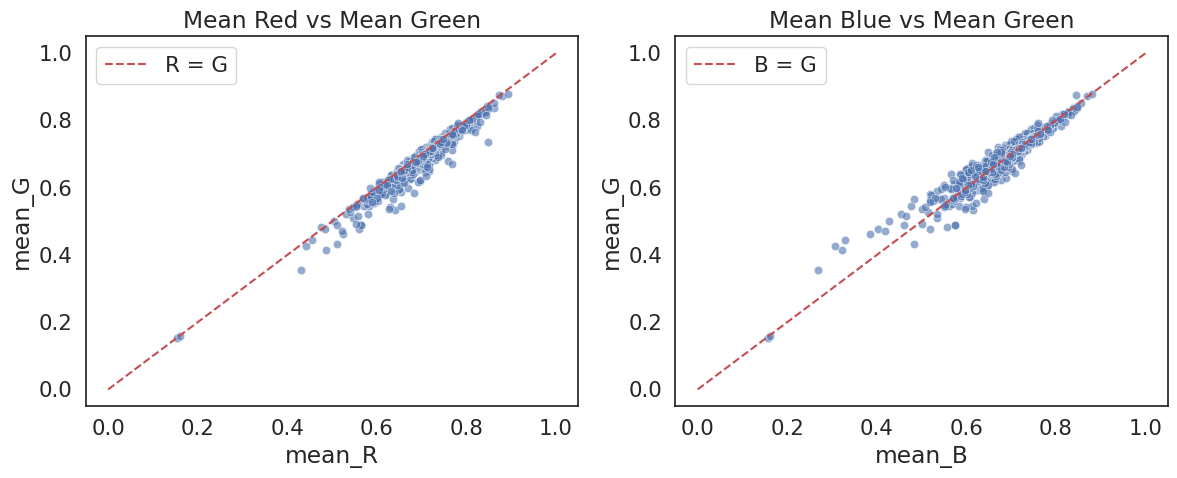

In [14]:
# Visualize the relationship between Mean Red and Mean Green to spot outliers
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=channel_stats_df, x="mean_R", y="mean_G", alpha=0.6)
plt.title("Mean Red vs Mean Green")
plt.plot([0, 1], [0, 1], 'r--', label="R = G")
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(data=channel_stats_df, x="mean_B", y="mean_G", alpha=0.6)
plt.title("Mean Blue vs Mean Green")
plt.plot([0, 1], [0, 1], 'r--', label="B = G")
plt.legend()

plt.tight_layout()
plt.show()

Top 20 potential outliers by Green Excess:


,sample_index,mean_R,mean_G,mean_B,std_R,std_G,std_B,green_excess
365,img_0365.png,0.454494,0.443050,0.328526,0.210312,0.203343,0.249063,0.051540
269,img_0269.png,0.440578,0.425582,0.307641,0.222104,0.217654,0.253816,0.051473
193,img_0193.png,0.578843,0.567274,0.482155,0.200986,0.203278,0.276888,0.036775
930,img_0930.png,0.504063,0.501990,0.426780,0.232926,0.233856,0.283379,0.036568
1015,img_1015.png,0.647505,0.640277,0.566301,0.190722,0.197663,0.269477,0.033374
104,img_0104.png,0.483561,0.476201,0.402447,0.269558,0.265017,0.303333,0.033197
291,img_0291.png,0.552971,0.544688,0.475583,0.102984,0.107976,0.196293,0.030410
1218,img_1218.png,0.698631,0.714093,0.674674,0.069698,0.040825,0.128732,0.027440
866,img_0866.png,0.667386,0.682432,0.643584,0.068794,0.052492,0.124814,0.026947
919,img_0919.png,0.678636,0.672744,0.613226,0.178592,0.183288,0.271058,0.026813


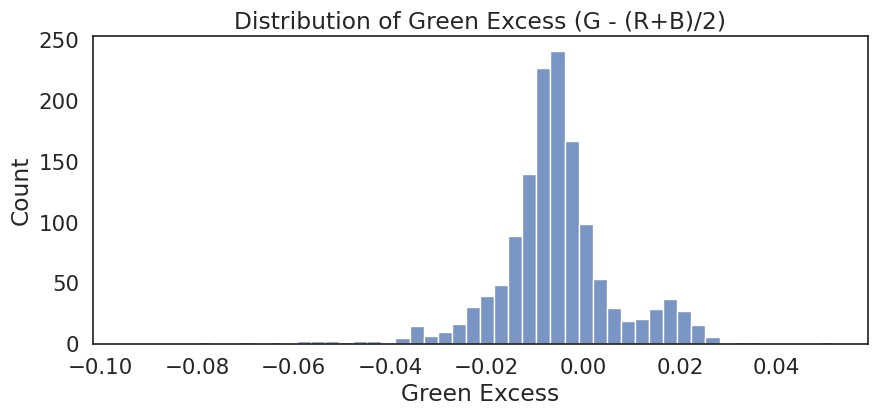

In [15]:
# Calculate "Green Excess" to identify Shrek and Green Stains
# Normal H&E images are Pink (High R, High B, Low G) or Purple (High B, Low R, Low G).
# Outliers (Shrek/Green Stains) will have higher Green values relative to Red and Blue.

channel_stats_df['green_excess'] = channel_stats_df['mean_G'] - ((channel_stats_df['mean_R'] + channel_stats_df['mean_B']) / 2)

# Sort by green excess to find the most "green" images
potential_outliers = channel_stats_df.sort_values(by='green_excess', ascending=False)

print("Top 20 potential outliers by Green Excess:")
display(potential_outliers.head(20))

# Plot distribution of Green Excess
plt.figure(figsize=(10, 4))
sns.histplot(channel_stats_df['green_excess'], bins=50)
plt.title("Distribution of Green Excess (G - (R+B)/2)")
plt.xlabel("Green Excess")
plt.show()

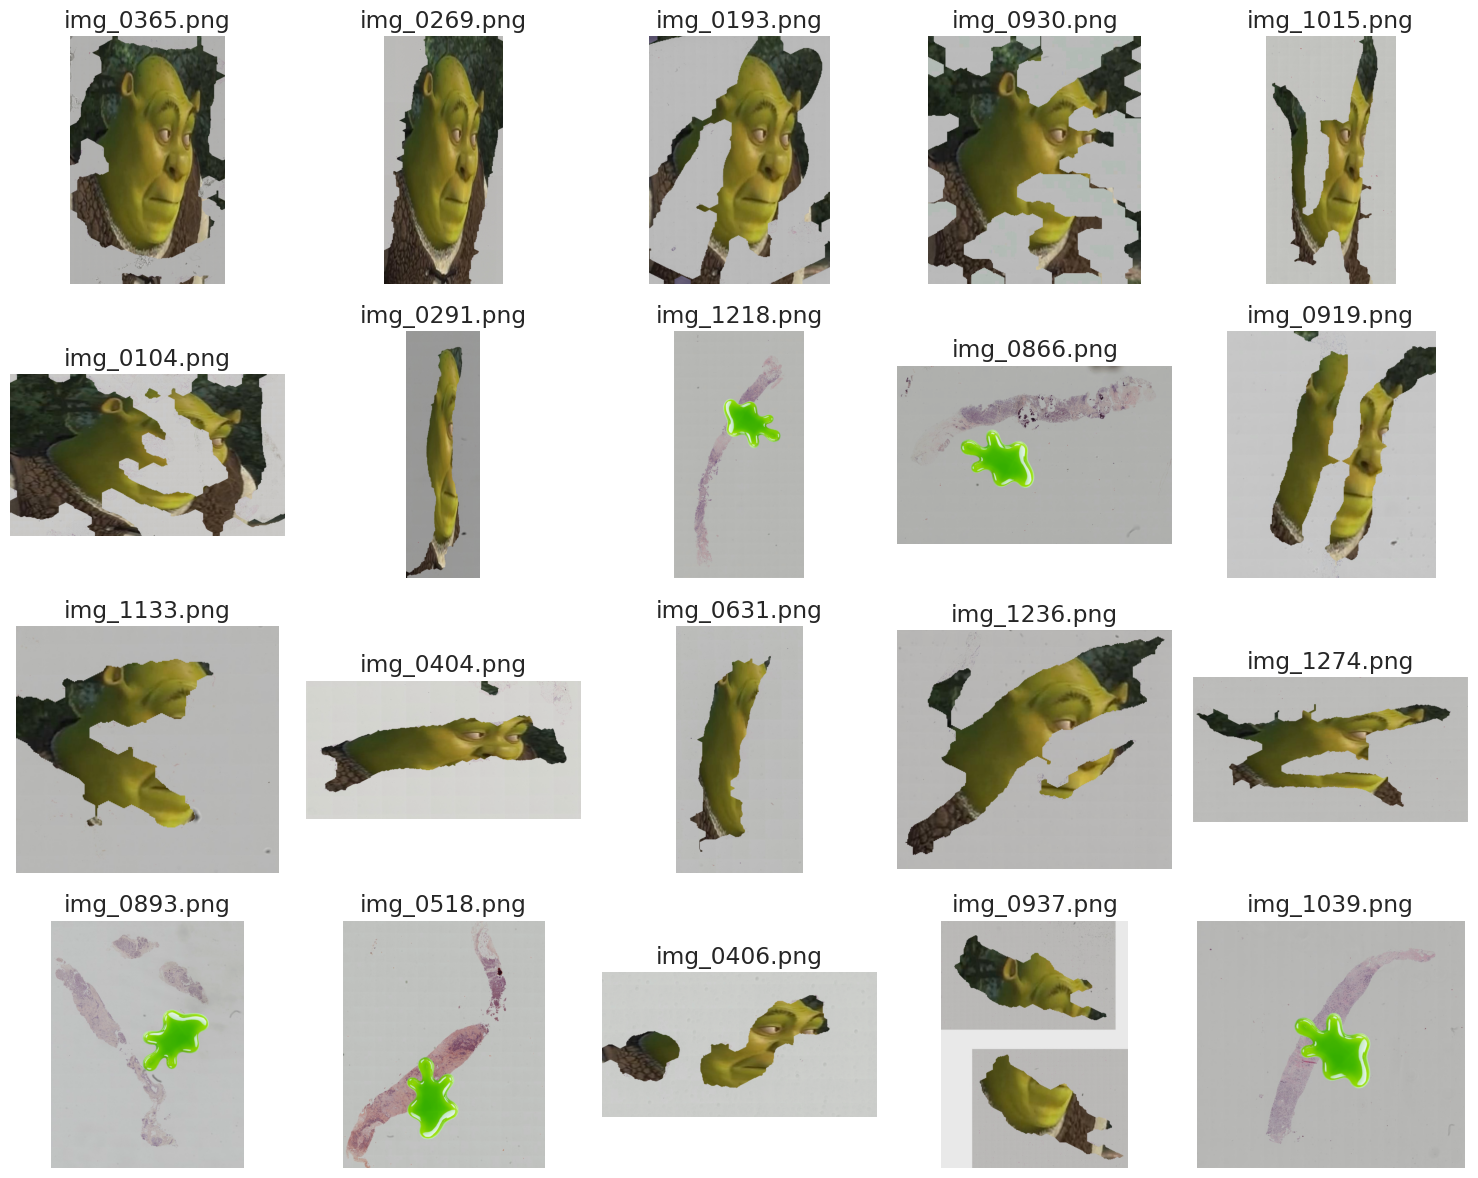

In [19]:
# Function to display images
def show_images(image_names, dir_path, cols=5):
    rows = (len(image_names) + cols - 1) // cols
    plt.figure(figsize=(15, 3 * rows))
    for i, img_name in enumerate(image_names):
        img_path = os.path.join(dir_path, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.title(img_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the top 20 outliers to visually confirm
outlier_names = potential_outliers.head(20)['sample_index'].tolist()
show_images(outlier_names, train_set_dir)

Identified 300 outliers with Green Excess > 0.0
Original dataset size: 1412
Cleaned dataset size: 1112
Sample clean images:


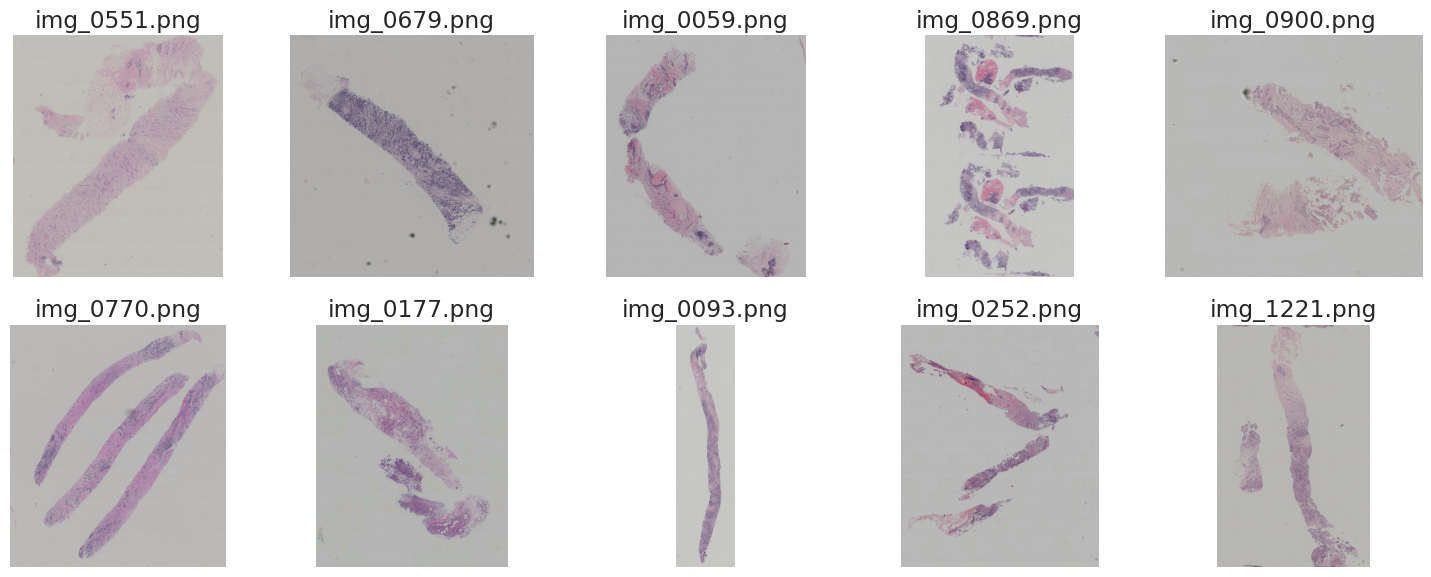

In [20]:
# Define a threshold for Green Excess based on the plot above
# You should adjust this value after inspecting the histogram and the images.
# A value around 0.0 or -0.05 might be appropriate to separate green images from H&E.
GREEN_THRESHOLD = 0.0

# Identify confirmed outliers
confirmed_outliers = channel_stats_df[channel_stats_df['green_excess'] > GREEN_THRESHOLD]
print(f"Identified {len(confirmed_outliers)} outliers with Green Excess > {GREEN_THRESHOLD}")

# Create a clean dataframe
clean_df = full_df[~full_df['sample_index'].isin(confirmed_outliers['sample_index'])]
print(f"Original dataset size: {len(full_df)}")
print(f"Cleaned dataset size: {len(clean_df)}")

# Display some of the "clean" images to verify they look normal
print("Sample clean images:")
show_images(clean_df.sample(10)['sample_index'].tolist(), train_set_dir)